# Website of the project : https://c-lefebvre.github.io/ADA_Homeworks/

# Basic analysis of the full dataset using PySpark

## What's in this section ?
- Here we load large datasets locally using Spark. We first load the full_ratings dataset to vizualise the distribution of the reviews and ratings.
- Then we load the full dataset by category. 
- We use these datasets to vizualise the distribution of the reviews with interactive graph 

In [5]:
# Import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark import SparkConf
import pandas as pd
import numpy as np


# Import the libraries to draw
import matplotlib.pyplot as plt
import seaborn as sns

# Import helpers functions
from spark_helpers import *

#Create a spark session
spark = SparkSession.builder.appName("Spark Session").config("spark.sql.crossJoin.enabled","true").getOrCreate()
sc = SparkContext.getOrCreate()

## Full Rating Analysis

First, we study the distribution of the full ratings. To do that we load the full ratings (3.37Go) and treat it with PySpark. We will output the distribution of the number of products relative to the number of reviews (i.e 10 products have 15 reviews ...).

In [2]:
# Load the full ratings data
df_full_ratings = spark.read.format('csv').option("header","false").load('DataSets/all_ratings.csv')
df_full_ratings.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)



In [3]:
# Display the first 20 rows 
df_full_ratings.take(10)

[Row(_c0='A3AF8FFZAZYNE5', _c1='0000000078', _c2='5.0', _c3='1092182400'),
 Row(_c0='AH2L9G3DQHHAJ', _c1='0000000116', _c2='4.0', _c3='1019865600'),
 Row(_c0='A2IIIDRK3PRRZY', _c1='0000000116', _c2='1.0', _c3='1395619200'),
 Row(_c0='A1TADCM7YWPQ8M', _c1='0000000868', _c2='4.0', _c3='1031702400'),
 Row(_c0='AWGH7V0BDOJKB', _c1='0000013714', _c2='4.0', _c3='1383177600'),
 Row(_c0='A3UTQPQPM4TQO0', _c1='0000013714', _c2='5.0', _c3='1374883200'),
 Row(_c0='A8ZS0I5L5V31B', _c1='0000013714', _c2='5.0', _c3='1393632000'),
 Row(_c0='ACNGUPJ3A3TM9', _c1='0000013714', _c2='4.0', _c3='1386028800'),
 Row(_c0='A3BED5QFJWK88M', _c1='0000013714', _c2='4.0', _c3='1350345600'),
 Row(_c0='A2SUAM1J3GNN3B', _c1='0000013714', _c2='5.0', _c3='1252800000')]

We see in the schema that the ratings and UNIX time are stored as string, to do computation on them we cast the columns as float numbers.

In [4]:
# Cast the ratings and UNIX time as float number
df_full_ratings = df_full_ratings.select(df_full_ratings._c0, df_full_ratings._c1, df_full_ratings._c2.cast('float')\
                                         ,df_full_ratings._c3.cast('float'))

In [5]:
# Rename the columns and print the new schema
df_full_ratings = df_full_ratings.selectExpr("_c0 as reviewerID", "_c1 as asin", "_c2 as ratings", "_c3 as UNIX_time")
df_full_ratings.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- ratings: float (nullable = true)
 |-- UNIX_time: float (nullable = true)



### Number of reviews by product
First we compute the number of reviews by product to see its distribution.

In [6]:
# Do a Group By Product of all the ratings
groupRatingsByProduct = df_full_ratings.groupBy('asin')
# Compute the number of reviews by product
ratings_count_by_product = groupRatingsByProduct.count()

In [7]:
ratings_count_by_product.take(5)

[Row(asin='0001714422', count=2),
 Row(asin='0001837192', count=1),
 Row(asin='0001845357', count=1),
 Row(asin='0002151731', count=1),
 Row(asin='0002158140', count=1)]

In [8]:
ratings_count_by_product = ratings_count_by_product.selectExpr('asin', 'count as number_of_review')
ratings_count_by_product.printSchema()

root
 |-- asin: string (nullable = true)
 |-- number_of_review: long (nullable = false)



Here we have two options:

- Collect the full dataframe with the number of reviews for each items, the problem with this approach is that we have a high number of products (a little less than 10M). So the pandas dataframe would be too large.

- The second option is to group the spark dataframe by number of reviews, for example we group together all the products that have exactly 4 reviews. With this method we will significantly reduce the size of the dataframe and can use it with pandas. 

We went with the second option :

In [9]:
# We group by the number of reviews
groupByNumberOfReviews = ratings_count_by_product.groupBy('number_of_review')

In [10]:
# We count the number of articles for each number of reviews
tmp_df = groupByNumberOfReviews.count()
# Some renaming for easier use
tmp_df = tmp_df.selectExpr('number_of_review', 'count as number_of_product')

In [11]:
# Compute the number of reviews by product as a pandas dataframe for easier use
df_ratings_count_pd = tmp_df.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_count_pd.to_csv('DataSets/Processed/Full_ratings_count.csv')

In [12]:
df_ratings_count_pd.describe()

,number_of_review,number_of_product
count,2802.000000,2.802000e+03
mean,2072.989650,3.523987e+03
std,2436.728958,9.448883e+04
min,1.000000,1.000000e+00
25%,701.250000,1.000000e+00
50%,1418.500000,3.000000e+00
75%,2482.250000,1.600000e+01
max,25368.000000,4.615058e+06


In [13]:
number_of_product = df_ratings_count_pd.sum()
number_of_product = number_of_product['number_of_product']
print('There is ' + str(number_of_product) + ' products in the dataset')

There is 9874211 products in the dataset


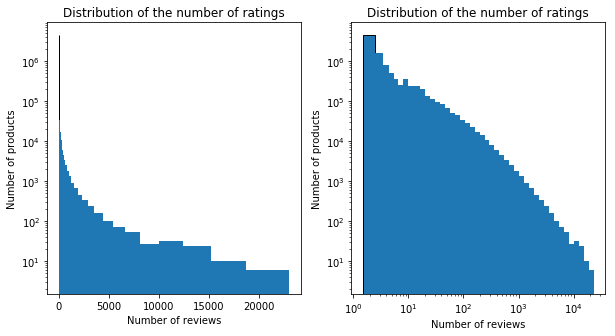

In [14]:
#Function used to draw the distribution of number of reviews per number of products
draw_full_ratings('DataSets/Processed/Full_ratings_count.csv')

We nearly have a power law.

### Ratings distribution

We now observe the distribution of the ratings.

In [15]:
# Do a Group By Product of all the ratings
groupRatingsByRating = df_full_ratings.groupBy('ratings')
# Compute the number of reviews by product
ratings_count_by_rating = groupRatingsByRating.count()

In [16]:
ratings_count_by_rating = ratings_count_by_rating.selectExpr('ratings', 'count as number_of_review')
ratings_count_by_rating.printSchema()

root
 |-- ratings: float (nullable = true)
 |-- number_of_review: long (nullable = false)



In [17]:
# Compute the number of ratings by rating as a pandas dataframe for easier use
df_ratings_distribution_pd = ratings_count_by_rating.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_distribution_pd.to_csv('DataSets/Processed/Full_ratings_distribution.csv')

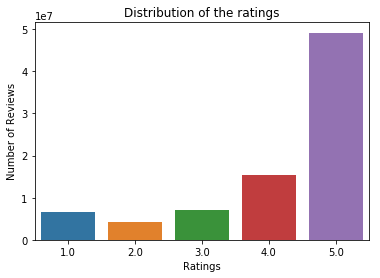

In [18]:
ax = sns.barplot(x = df_ratings_distribution_pd['ratings'], y = df_ratings_distribution_pd['number_of_review'])
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of the ratings')
plt.show()

The ratings have a clear tendency to be >=4 

## Analysis of the distribution for each categories

Here are implemented functions used to load a category and output the distributions of the reviews

In [6]:
import pickle
import pandas as pd

def compute_rating_distribution(name_to_read,name_to_save):
    """Function used to load a full json category dataset using spark and process it
    by computing the number of review per product and the number of review per rating and
    save the processed dataframe into two files"""
    df = load_file_cat(name_to_read,'json',spark)
    df_review = compute_review_per_product(df,'DataSets/Processed/'+name_to_save+'_Review_Count.csv')   
    df_rating = compute_review_per_rating(df,'DataSets/Processed/'+name_to_save+'_Ratings_Count.csv')



def compute_every_ratings_distribution(list_of_categories):
    """Call the compute_rating_distribution for every categories given in the list"""
    for category in list_of_categories:
        compute_rating_distribution('DataSets/reviews_'+category+'.json.gz', category)


def add_to_dictionnary(dictionnary_ratings,dictionnary_review, category):
    """Add the two dataframe containing the distribution for each category to a dictionnary of dataframe"""
    
    # Number of reviews per rating
    df = pd.read_csv('DataSets/Processed/'+category+'_Ratings_Count.csv')
    df['count'] = df['count']/np.sum(df['count']) # Compute the proportions
    # Add the dataframe to the dictionnary
    dictionnary_ratings[category] = df
    
    # Number of reviews per product
    df_review_count_pd = pd.read_csv('DataSets/Processed/'+category+'_Review_Count.csv')[['asin','count']]
    df_review_count = df_review_count_pd.groupby('count').count()# Count the items that have the same numer of reviews
    df_review_count = df_review_count.reset_index()
    df_review_count.columns = ['Review_Count', 'Product_Count']   
    # Add the dataframe to the dictionnary
    dictionnary_review[category] = df_review_count
    
def create_dictionnary_dataframe(list_of_categories):
    """Function used to initialize and fill the dictionnary containing all the dataframes by putting the dataframes for 
    all categories"""
    #Read the stored csv of the number of reviews per product
    df_full_review_count = pd.read_csv('DataSets/Processed/Full_ratings_count.csv')[['number_of_review','number_of_product']]
    df_full_review_count.sort_values('number_of_review',inplace=True)    
    df_full_review_count.columns = ['Review_Count', 'Product_Count']
    #Add the dataframe to the dictionnary
    full_reviews_dict = {'Full' : df_full_review_count}

    #Read the stored csv of the number of reviews per rating
    full_ratings = pd.read_csv('DataSets/Processed/Full_ratings_distribution.csv')
    full_ratings.sort_values('ratings',inplace=True)
    #Compute the proportions
    full_ratings['number_of_review'] = full_ratings['number_of_review']/np.sum(full_ratings['number_of_review'])   
    #Add the dataframe to the dictionnaey
    ratings_count_dict = {'Full' : full_ratings}
    
    #Fill the dictionnary with all the different categories
    for category in list_of_categories:
        add_to_dictionnary(ratings_count_dict, full_reviews_dict, category)

    # Save the dictionnary containing the number of reviews per product for each category
    output = open('DataSets/Processed/ReviewCountDict.pkl', 'wb')
    pickle.dump(full_reviews_dict, output)
    output.close()
    
    # Save the dictionnary containing the number of reviews per rating for each category    
    output = open('DataSets/Processed/RatingsCountDict.pkl', 'wb')
    pickle.dump(ratings_count_dict, output)
    output.close()    
    

In [7]:
# This is the list of all available categories
list_of_cat = ['Books','Electronics', 'Movies_and_TV','CDs_and_Vinyl', 'Clothing_Shoes_and_Jewelry',
              'Home_and_Kitchen', 'Kindle_Store', 'Sports_and_Outdoors', 'Cell_Phones_and_Accessories',
              'Health_and_Personal_Care', 'Toys_and_Games', 'Video_Games', 'Tools_and_Home_Improvement',
              'Beauty', 'Apps_for_Android','Office_Products','Pet_Supplies', 'Automotive', 'Grocery_and_Gourmet_Food',
              'Patio_Lawn_and_Garden', 'Baby', 'Digital_Music', 'Musical_Instruments', 'Amazon_Instant_Video']

In [8]:
#Warning this line can be quite long to run (Approx 30min)
#compute_every_ratings_distribution(list_of_cat)

In [9]:
#Fill the two dictionnaries which will contain all the categories
create_dictionnary_dataframe(list_of_cat)

In [10]:
def log_bar_plot_helper(dataframe):
    """ Helper function to get the left edge position of the
        bars in a bar plot, the width of the bars and the 
        corresponding values
    """
    df = dataframe.copy()
    # Create logarithmic repartition of the bins
    bins = np.logspace(np.floor(np.log10(np.amin(df['Review_Count']))), np.log10(np.amax(df['Review_Count'])))
    # Make sure values are integers and remove duplicate
    bins = np.unique(np.round(bins))
    # Add 0 to the array
    bins = np.concatenate([np.array([0]), bins])
    df['Bin'] = pd.cut(df.Review_Count, bins)
    counts = df.groupby('Bin')['Product_Count'].sum()
    middles = [(counts.index[i].left + counts.index[i+1].left)/2.0 for i in range(len(counts.index)-1)]
    middles.append((counts.index[-1].left + counts.index[-1].right)/2.0)
    middles = np.array(middles)
    widths = np.diff(middles)
    #Compute the median
    median = df['Product_Count'].median()+1
    return (middles, counts.values, widths, median)

In [11]:
#Do the necessary import for the graphs
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, ColumnDataSource, Select, Slider
from bokeh.plotting import Figure, output_file, show,save
from bokeh.io import output_notebook
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [12]:
#Here is a list of tuplet with the first element being the keyword to recognize a category for the graphs 
#and the second element is the displayed category on the selection box in the graph
categories_selection_list = [('Full', 'All Categories'),('Books','Books'), ('Electronics', 'Electronics')
                             ,('Movies_and_TV', 'Movies and TVs'),('CDs_and_Vinyl','CDs and Vinyl')
                             ,('Clothing_Shoes_and_Jewelry', 'Clothing Shoes and Jewelry')
                             ,('Home_and_Kitchen','Home and Kitchen'),('Kindle_Store','Kindle Store')
                             ,('Sports_and_Outdoors', 'Sports and Outdoors')
                             ,('Cell_Phones_and_Accessories', 'Cell Phones and Accessories')
                             ,('Health_and_Personal_Care','Health and Personal Care')
                             ,('Toys_and_Games', 'Toys and Games'),('Video_Games','Video Games')
                             ,('Tools_and_Home_Improvement', 'Tools and Home Improvement')
                             ,('Beauty','Beauty'),('Apps_for_Android', 'Apps for Android')
                             ,('Office_Products', 'Office Products'),('Pet_Supplies','Pet Supplies')
                             ,('Automotive', 'Automotive'),('Grocery_and_Gourmet_Food', 'Grocery and Gourmet Food')
                             ,('Patio_Lawn_and_Garden', 'Patio Lawn and Garden'),('Baby','Baby')
                             ,('Digital_Music', 'Digital Music'),('Musical_Instruments', 'Musical Instruments')
                             ,('Amazon_Instant_Video', 'Amazon Instant Video')]

##### Plot of the number of products per number of reviews

In [13]:
# Decomment the first line if you want to save the graph as an html file

#output_file("Graph/BokehGraph_Review_per_Product.html")
output_notebook()

# Load the dictionnary containing the dataframe for each category
pkl_file = open('DataSets/Processed/ReviewCountDict.pkl', 'rb')
full_reviews_dict = pickle.load(pkl_file)

# Initialize the data for the graph by giving it the dataframe for all products regardless of category
# Data is for plotting the distribution and data2 is for plotting the median
bar_plot_full_helper = log_bar_plot_helper(full_reviews_dict['Full'])
data={'Review_Count' : bar_plot_full_helper[0], 'Product_Count' : bar_plot_full_helper[1],
      'Width' : bar_plot_full_helper[2],
      'RC_Full' : bar_plot_full_helper[0], 'PC_Full' : bar_plot_full_helper[1]
     ,'Width_Full' : bar_plot_full_helper[2]}

data2 = {'Median' : [bar_plot_full_helper[3],bar_plot_full_helper[3]], 'Straight_Line' : [0.001, 10000000], 
         'Median_Full' : [bar_plot_full_helper[3],bar_plot_full_helper[3]]}

# Fill the graph data sources for each category
for category in list_of_cat:
    bar_plot_helper = log_bar_plot_helper(full_reviews_dict[category])
    data['RC_'+category] = bar_plot_helper[0]
    data['PC_'+category] = bar_plot_helper[1]
    data['Width_'+category] = bar_plot_helper[2]
    data2['Median_'+category] = [bar_plot_helper[3],bar_plot_helper[3]]
    
#Transform the two data sources into Bokeh data sources
source = ColumnDataSource(data) #For the distribution
source2 = ColumnDataSource(data2) #For the Median

#Initialize the plot
plot = Figure(plot_width=400, plot_height=300,x_axis_type = 'log',y_axis_type= 'log',x_range = [10e-1,10e4],y_range=[10e-2, 10e6], x_axis_label = 'Number of reviews',
             y_axis_label = 'Number of products', tools = 'box_zoom,save,reset')

#Initialize the distribution plot
plot.vbar('Review_Count',top = 'Product_Count',bottom=0.01,alpha = 0.7,width = 'Width', color = 'LightCoral', source = source)
#Initialize the median plot
plot.line('Median', 'Straight_Line', color = 'blue', source = source2, legend = 'Median ')
plot.background_fill_color = "LightGray"
plot.background_fill_alpha = 0.4
plot.grid.grid_line_width = 1
plot.grid.grid_line_alpha = 1
plot.grid.grid_line_color = 'White'

def callback(source=source, source2=source2, window=None):
    """Callback function which will be interpreted in javascript. This function is called each time
    the category is change and update the data source accordingly"""
    #Load the Bokeh data sources
    data = source.data
    data2 = source2.data
    #Get the selected category
    f = cb_obj.value
    x, y, width= data['Review_Count'], data['Product_Count'], data['Width']
    med = data2['Median']
    cat_x = 'RC_'+f
    cat_y = 'PC_'+f
    cat_width = 'Width_'+f
    cat_med = 'Median_'+f
    #Update the median
    med[0] = data2[cat_med][0]
    med[1] = data2[cat_med][1]
    #Update the distribution
    for i in range(len(x)):
        x[i] = data[cat_x][i]
        y[i] = data[cat_y][i]
        width[i] = data[cat_width][i]
    #Broadcast the change to the graph
    source.change.emit()
    source2.change.emit()

#Initialize the dropdown selection menu
category_select = Select(value='Full', title="Category", options=categories_selection_list,
                callback=CustomJS.from_py_func(callback))
#Create the layout
layout = row(plot, category_select)
#Show the graph
show(layout)

Loading BokehJS ...

##### Plot of the number of reviews per each rating

In [14]:
# Uncomment the first line if you want to save the graph as an html file

#output_file("Graph/BokehGraph_Review_per_Ratings.html")
output_notebook()

# Load the dictionnary containing the dataframe for each category
pkl_file = open('DataSets/Processed/RatingsCountDict.pkl', 'rb')
ratings_count_dict = pickle.load(pkl_file)

# Initialize the data for the graph by giving it the dataframe for all products regardless of category
# Data is for plotting the distribution
data = {'Review_Count' : ratings_count_dict['Full']['number_of_review'],
       'Ratings' : ratings_count_dict['Full']['ratings'],
       'Review_Count_Full' : ratings_count_dict['Full']['number_of_review']}

# Fill the graph data source for each category
for category in list_of_cat:
    data['Review_Count_'+category] = ratings_count_dict[category]['count']
    
#Transform the data source into Bokeh data source
source = ColumnDataSource(data)

#Initialize the plot
plot = Figure(plot_width=400, plot_height=300, x_axis_label = 'Rating', y_axis_label = 'Proportion'
              ,y_range=[0, 1], tools = '')
plot.background_fill_color = "LightGray"
plot.background_fill_alpha = 0.4
plot.grid.grid_line_width = 1
plot.grid.grid_line_alpha = 1
plot.grid.grid_line_color = 'White'

#Initialize the ratings plot
plot.vbar('Ratings',top = 'Review_Count',bottom=0,width = 0.8, source = source, color = 'LightCoral',alpha = 0.7)

def callback1(source=source, window=None):
    """Callback function which will be interpreted in javascript. This function is called each time
    the category is change and update the data source accordingly"""
    #Load the Bokeh data sources
    data = source.data
    #Get the selected category
    f = cb_obj.value
    x, y = data['Ratings'], data['Review_Count']
    cat_y = 'Review_Count_'+f
    #Update the graph
    for i in range(len(x)):
        y[i] = data[cat_y][i]
    #Broadcast the change
    source.change.emit()
    
#Initialize the dropdown category selection widget
category_select = Select(value='Full', title="Category", options=categories_selection_list)
category_select.js_on_change('value', CustomJS.from_py_func(callback1))

#Create the widget and plot layout
layout = row(plot,category_select)
#Plot the graph
show(layout)

Loading BokehJS ...

# Cleaning and analysis of the 5-core electronic data

## What's in this section?

In this section, we take a look at the review of products and its reviewer. More precisly we look in details at all the reviewers of a product and make analysis about what the reviewer reviewed before, what is its mean rating, mean length of its review in order to get more insight about the global rate of the product.  

For now, we just take the 5-core electronics reviews of our dataset and we will change later for all the reviews. This is just for milestone 2 and to help us building a pipeline for our project.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import ast
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

We create functions that are saved in helpers_functions.py. We provided comments and descriptions about this functions in the file but we summarize here that: 
- Some functions helps us load the dataframe correctly. (cleaning part)
- Some functions helps us enrich the dataset. (analysis part)
- Some functions helps us vizualise the data and get more insight about what we had. (plot part)

In [2]:
from helpers_functions import *

This part starts by reading and cleaning the data we got from the 5-core dataset provided. We decided to keep only the useful data and we change some columns in order to have it as we want. We dropped the time (UTC), the name of the reviewer, imageURL and the product description.

In [3]:
#Load the dataframe.
df = read_DataFrame_From_CSV()

#Reset the index.
df = df.reset_index()

#We fill the na values of the Review Text column with a string 'None'.
df['Review Text'] = df['Review Text'].fillna('None')

#df.set_index(['Reviewer ID','Product ID'])
df = df.set_index(['Reviewer ID','Product ID'])

#Look at the head.
df.head(2)

,,Product Title,Product Price,Brand,Categories,Review Summary,Review Rating,Review Text,Review Time,Helpfulness Votes,Sales Rank,Related Products
Reviewer ID,Product ID,,,,,,,,,,,
AO94DHGC771SJ,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",Gotta have GPS!,5.0,We got this GPS for my husband who is an (OTR)...,1370131200,"[0, 0]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
AMO214LNFCEI4,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",Very Disappointed,1.0,"I'm a professional OTR truck driver, and I bou...",1290643200,"[12, 15]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A3N7T0DY83Y4IG,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",1st impression,3.0,"Well, what can I say. I've had this unit in m...",1283990400,"[43, 45]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A1H8PY3QHMQQA0,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...","Great grafics, POOR GPS",2.0,"Not going to write a long review, even thought...",1290556800,"[9, 10]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."
A24EV6RXELQZ63,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"[[Electronics, GPS & Navigation, Vehicle GPS, ...","Major issues, only excuses for support",1.0,I've had mine for a year and here's what we go...,1317254400,"[0, 0]",{},"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '..."


In [4]:
#We read the CSV where we computed the sentiments of the reviews
sent = pd.read_csv('ElecSentimentOnly.csv',index_col = [1,0])

#we merge the df we had and the sentiments
df_s = pd.merge(df,sent,left_index=True,right_index=True)

#we made some manipulations in order to have different
#views of the dataframe
df = df_s
df_review = df.swaplevel(0,1) 
dft = df
df = df_review
df_review = dft

Now that our dataframe is clean we can check what are the most reviewed article and what are the least reviewed.

In [5]:
#Reset the index.
articles = df.reset_index()

#Set it as the product id.
articles = articles['Product ID']

#count all the values in the articles
articles = articles.value_counts()

#keep the 10 most reviewed article.
most_reviewed = articles[:10]

#keep the 10 least reviewed article.
least_reviewed = articles[-10:]

#have a look at the most reviewed
most_reviewed

B007WTAJTO    4915
B003ES5ZUU    4143
B00DR0PDNE    3798
B0019EHU8G    3435
B002WE6D44    2813
B003ELYQGG    2652
B0002L5R78    2599
B009SYZ8OC    2542
B00BGGDVOO    2104
B002V88HFE    2082
Name: Product ID, dtype: int64

In [6]:
#have a look at the least reviewed to take it as an example
#for the rest of the notebook.
least_reviewed

B004Y0H5LY    5
B0049SVU8K    5
B002ZDAEJ2    5
B004ZCS0TW    5
B004FLQRNO    5
B004AGN0C0    5
B000PB2OBW    5
B004W26IVC    5
B000233T80    5
B00AQ4ER2W    5
Name: Product ID, dtype: int64

We look at the data of a reviewer (of a certain product). It shows us the mean rate, the mean length of the reviews, the number of reviews as a dataframe.

In [7]:
#Data about reviewer A33WCB5866XN09.
#Function that computes statistics on the reviewer, it returns the mean rate, all the rates, the length and the mean 
#lengths of all reviews, the number of reviews and the categories of the item it purchases.
stat_reviewer = statistics(dft,'A33WCB5866XN09')
stat_reviewer

,Reviewer,length curr_review,mean_rates,mean_review_length,number_reviews,rates,review(s)_length,Electronics,Portable Audio & Video,MP3 Players & Accessories,...,Audio & Video Accessories,TV Accessories & Parts,Rear Projection TV Replacement Lamps,Telephone Accessories,Batteries,Car & Vehicle Electronics,Vehicle Electronics Accessories,Antennas,Computer Cable Adapters,Hard Drive Enclosures
0,A33WCB5866XN09,29,4.9,44.5,10,"[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[29, 35, 31, 33, 21, 124, 24, 27, 57, 64]",10,1,1,...,3,2,2,1,1,1,1,1,1,1


We can do the same with a product and have the detailed data of all the reviewers of this product.

In [8]:
#Data about product B00005NHAK.
#Function that returns the statistics about all the reviewer of a product. 
#See helpers_functions.py for more details.
stat_product = statistics_product(dft,'B00005NHAK')

#look at the result.
stat_product

,Reviewer,Rate reviewer,mean_rates,length curr_review,mean_review_length,number_reviews,rates,review(s)_length,Electronics,APS Cameras,...,USB Flash Drives,USB Network Adapters,USB Port Cards,Vehicle Electronics Accessories,Video Cables,Video Surveillance,Webcams,Wireless Access Points,Zip Discs,xD-Picture Cards
0,A3E0PQ1LJAKWZ,2.0,2.818182,86,67.000000,11,"[2.0, 1.0, 5.0, 5.0, 3.0, 2.0, 4.0, 1.0, 1.0, ...","[86, 48, 28, 77, 32, 164, 51, 22, 90, 108, 31]",11,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A7IKOAH6M8WAC,5.0,4.285714,36,84.000000,14,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 1.0, ...","[36, 29, 56, 66, 214, 28, 111, 28, 63, 117, 88...",14,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,A2HONG3KI05QIX,4.0,4.857143,51,146.714286,7,"[5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0]","[51, 134, 274, 51, 102, 128, 287]",7,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A231WM2Z2JL0U3,4.0,4.401235,69,158.839506,162,"[4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ...","[69, 62, 66, 68, 86, 41, 227, 119, 67, 76, 48,...",162,1.0,...,3.0,4.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
4,AWW0JIUH84TIK,3.0,3.526316,171,251.368421,19,"[3.0, 4.0, 4.0, 1.0, 4.0, 4.0, 1.0, 3.0, 5.0, ...","[171, 154, 138, 160, 267, 123, 184, 28, 137, 4...",18,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's vizualise some data.

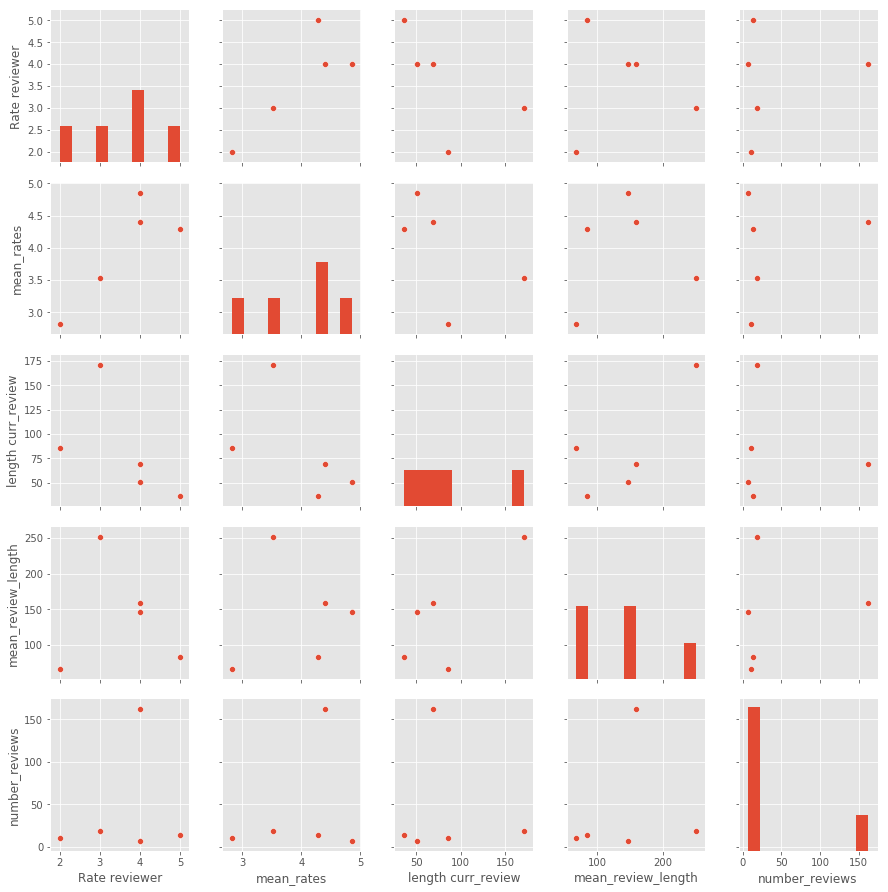

In [17]:
#Analyse the parity of the columns.
#Function that plot the parity of the columns of interest of our review-dataframe.
analyse_pair(stat_product)

We focus on computing a new rate for a given product. In order to have some nice results, we beforehand get more insight about the product itself. We display some plots to help us to visualize what's going on.

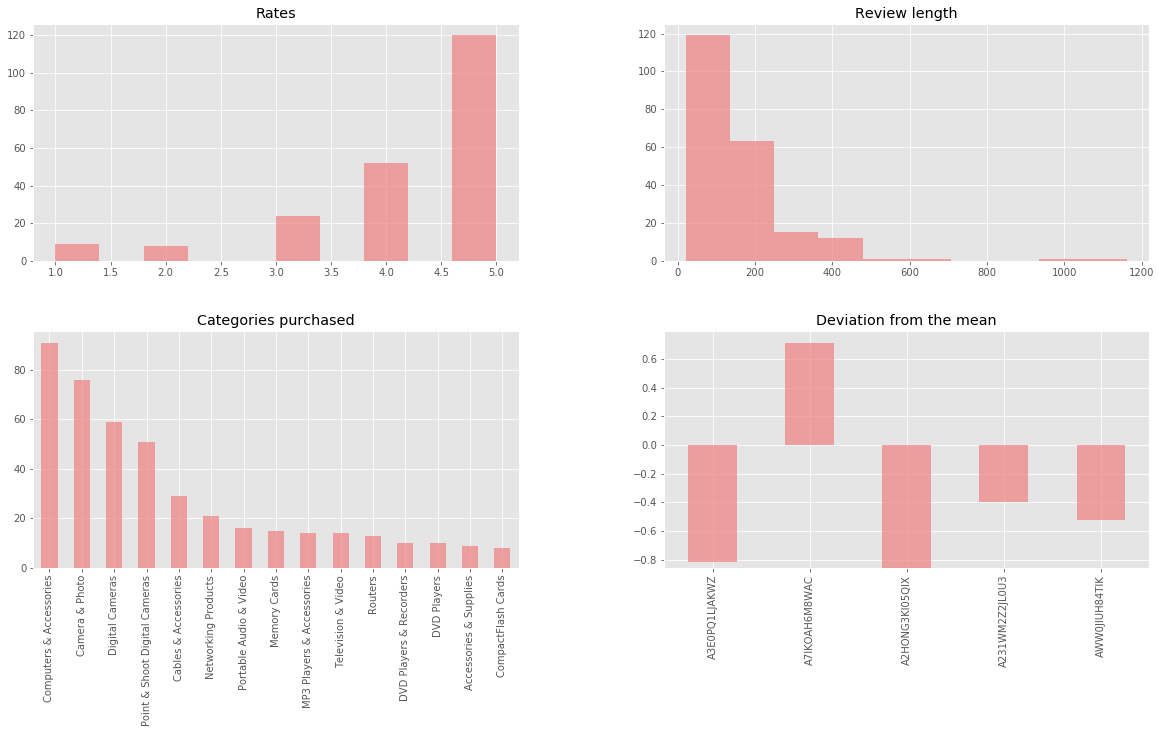

In [34]:
#other plots.
#Function that plot some interesting plots
analyse_ref(stat_product)

In [19]:
cat = stat_product[stat_product.columns[9:]].sum(axis=0).sort_values()[::-1][:15]
cat

Computers & Accessories          91.0
Camera & Photo                   76.0
Digital Cameras                  59.0
Point & Shoot Digital Cameras    51.0
Cables & Accessories             29.0
Networking Products              21.0
Portable Audio & Video           16.0
Memory Cards                     15.0
MP3 Players & Accessories        14.0
Television & Video               14.0
Routers                          13.0
DVD Players & Recorders          10.0
DVD Players                      10.0
Accessories & Supplies            9.0
CompactFlash Cards                8.0
dtype: float64

In [20]:
#Correlation between the length of the review and the rate.
#Function that calculate the correlation between the length of the review and the rate of the review.
corr = corr_len_rate(stat_product)
corr

,length curr_review,Rate reviewer
length curr_review,1.000000,-0.588072
Rate reviewer,-0.588072,1.000000


# Sentiment analysis

## What's in this section ?

In this part, we work on the reviews of the product in the Electronics category, read from the 5-core data set. We want to analyze the sentiment that is given by the review : is it positive or negative ? How does it relate to the rating given by the reviewer ?

To do this, we use the nltk python library, in particular the Vader module which can determine the sentiment of a text. The library provides a grade of the positiveness and negativeness of a text, and an average of the two : compound. We will use this last value for our analysis.

We start by importing the nltk library and the `Vader` module

In [33]:
import nltk.data

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

In [34]:
# We instantiate the sentiment analizer 
sid = SentimentIntensityAnalyzer()
# lmtzr = WordNetLemmatizer()

We wrap the computation of the nltk compound score of a text in a helper function.

In [35]:
def overall_score(text):
    """ Computes a unique value of sentiment positiveness for the input text 
        Returns: (positiveness_score - negativeness_score) * compound
    """
    polarity_score = sid.polarity_scores(text)
    return polarity_score['compound'] # (blob['pos'] - blob['neg']) * blob['compound']

In [36]:
text = 'marvelous and awful'

In [37]:
sid.polarity_scores(text)

{'compound': 0.2263, 'neg': 0.38, 'neu': 0.127, 'pos': 0.494}

In [38]:
overall_score(text)

0.2263

We wish to see if the distribution of the sentiment is similar to the distribution of the ratings. To better compare the data, we will map the sentiment from \[-1, 1\] to the range of the ratings : \[1,5\]

In [39]:
def mapSentimentToRating(Sentiment):
    """ Maps the sentiment rating of a review (real number between -1 and 1) to
        a rating between 1 and 5. """
    # We use a linear mapping : for any number x in [-1, 1], we map the value
    # (x - (-1)) * (5-1)/(1-(-1)) + 1
    return (Sentiment+1)*2 +1

We will first analyse the sentiment given by the summary (title) of the reviews, and then we will analyse the sentiment given by the texts of the reviews.

We create a new column in the dataframe to store the sentiment of the summary of the reviews, and fill it with the values computed with nltk.

In [40]:
Elec_Data = df

Elec_Data['Review Summary Sentiment'] = np.NaN

Elec_Data['Review Summary Sentiment'] = Elec_Data['Review Summary'].map(lambda r: overall_score(str(r)))

Elec_Data['Review Summary Sentiment'].describe()

count    1.689188e+06
mean     2.877538e-01
std      3.564592e-01
min     -9.691000e-01
25%      0.000000e+00
50%      3.919000e-01
75%      6.249000e-01
max      9.911000e-01
Name: Review Summary Sentiment, dtype: float64

We now map the sentiment to \[1, 5\] to compare them with the gradings

In [41]:
Elec_Data['Review Summary Sentiment'] = mapSentimentToRating(Elec_Data['Review Summary Sentiment'])

In [42]:
Elec_Data['Review Summary Sentiment'].describe()

count    1.689188e+06
mean     3.575508e+00
std      7.129184e-01
min      1.061800e+00
25%      3.000000e+00
50%      3.783800e+00
75%      4.249800e+00
max      4.982200e+00
Name: Review Summary Sentiment, dtype: float64

We plot the distribution of the sentiment ratings

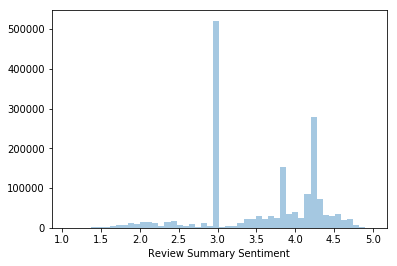

In [45]:
sns.distplot(Elec_Data['Review Summary Sentiment'], kde = False)
plt.show()

The distribution displays two peaks : a center at 3 which indicates a neutral feeling, and a pick between 3.5 and 4.5 which correspond to positive feelings. Most of the reviews feelings are thus neutral or positive.

We now compute the sentiment given by the full text of the reviews

In [46]:
Elec_Data['Review Sentiment'] = np.NaN

In [47]:
Elec_Data['Review Sentiment'] = Elec_Data['Review Text'].map(lambda r: overall_score(str(r)))

In [48]:
Elec_Data['Review Sentiment'].describe()

count    1.689188e+06
mean     5.611259e-01
std      5.047354e-01
min     -9.996000e-01
25%      3.642000e-01
50%      7.844000e-01
75%      9.283000e-01
max      1.000000e+00
Name: Review Sentiment, dtype: float64

We map the sentiment to the rating range :

In [49]:
Elec_Data['Review Sentiment'] = mapSentimentToRating(Elec_Data['Review Sentiment'])

In [50]:
Elec_Data['Review Sentiment'].describe()

count    1.689188e+06
mean     4.122252e+00
std      1.009471e+00
min      1.000800e+00
25%      3.728400e+00
50%      4.568800e+00
75%      4.856600e+00
max      5.000000e+00
Name: Review Sentiment, dtype: float64

As we can see, most of the sentiment of the reviews are between 4 et 5, which is a very positive sentiment. There is also a pick at 3, which correspond to a neutral feeling.

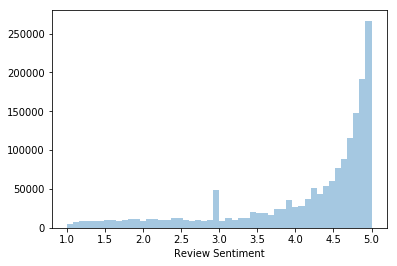

In [51]:
sns.distplot(Elec_Data['Review Sentiment'], kde = False)
plt.show()

We look at the distribution of the reviews sentiment per product:

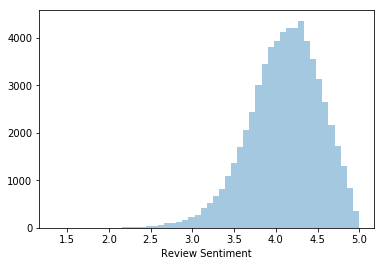

In [58]:
sns.distplot(Elec_Data.groupby(level=0)['Review Sentiment'].mean(), kde = False)
plt.show()

The distribution is very different. We can compare it to the distribution of ratings per product:

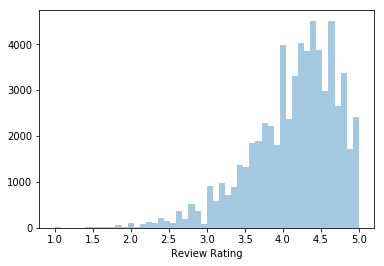

In [59]:
ax = sns.distplot(Elec_Data.groupby(level=0)['Review Rating'].mean(), kde = False)
plt.show()

## New Rating Computation
The method to compute the new rating is described in the data story (link at the start of the notebook)

We create some functions in order to compute the new ratings for our products.

In [21]:
def mapDiffToMeanToGrade(Sentiment, mean_sentiment):
    """ Maps the difference between the sentiment of a review and the mean sentiment of a reviewer to 
        [1, 5]
    """
    
    #return the results.
    return (Sentiment-mean_sentiment + 4)*(4/8) +1

In [22]:
def new_review_rating(df, df_review, productID, reviewID, ws, wsp, wgp):
    """ Computes a new rating of a review, with a component depending on the sentiment
    """
    #we take the mean.
    r_mean_ratings = np.mean(df_review.loc[reviewID,:]['Review Rating'])
    #we extract the review rating column.
    r_rating = df.loc[productID,reviewID]['Review Rating']
    #we extract the review sentiment column.
    r_sentiment = df.loc[productID,reviewID]['Review Sentiment']
    #we compute the mean.
    mean_sentiment = np.mean(df.loc[productID,:]['Review Sentiment'])
    #we return the new rating.
    return ws*wsp*r_sentiment, ws*(1-wsp)*mapDiffToMeanToGrade(r_sentiment,mean_sentiment), \
            (1-ws)*(1-wgp)*r_rating, (1-ws)*wgp*mapDiffToMeanToGrade(r_rating,r_mean_ratings)

In [23]:
def expertise(df_review, reviewerID, productCategory):
    """ Compute the expertise grade of a reviewer in the category of product 'productCategory'
    """
    #we use our get_category function we create.
    reviewer_nb_reviews_in_category = get_category(df_review.loc[reviewerID,:])[productCategory]
    #we return the expertise.
    return np.round(1 + 3*np.log(reviewer_nb_reviews_in_category))

In [25]:
def new_Product_Rating(df, df_review, productID, we, ws, wsp, wgp):
    """ Return the new rating of a product
    """
    
    #Extract the categories.
    product_Category = df.loc[productID,:]['Categories']
    #Creation of new lists.
    new_ratings = []
    r_expertise = []
    mean_expertises = []
   
    #for every product ID.
    for r in df.loc[productID,:].index:
        #Append the new ratings.
        new_ratings.append(new_review_rating(df, df_review, productID, r, ws, wsp, wgp))
        #check the expertise for every categories.
        r_expertise_for_category = [expertise(df_review, r, category) for category in get_category(df_review.loc[r,:])]
        #computing the mean.
        mean_expertises.append(np.mean(r_expertise_for_category))
        #append in the list.
        r_expertise.append(mean_expertises)
   
    #compute the rating of a product
    ratings,expert = (1-we)*np.mean(new_ratings, axis=0), we*np.average(new_ratings, weights = mean_expertises, axis=0)
    
    #return the results.
    return ratings[0], ratings[1], ratings[2], ratings[3], expert[0], expert[1], expert[2], expert[3]

We check the expertise.

In [24]:
expertise(df_review, 'A3N7T0DY83Y4IG','Electronics')

8.0

We can now compute the new rates as explained in the data story.

In [14]:
#We compute new ratings for these products.
produit = ['B002WGAHYY','B000ML4QGG','B000BRX798','B00D2ZEJ3Y','B007BJC75E']
tab_df = df.loc['0528881469',:]

#we use slice in m differents values.
m = 5
#create the new weights.
we =  np.linspace(0,1.0, m)
ws =  np.linspace(0,1.0, m)
wsp = np.linspace(0,1.0, m)
wgp = np.linspace(0,1.0, m)

#creathe the new lists.
rating = np.empty(tab_df.index.shape[0])
new_rating = np.empty([5,m,m,m,m,8])

#for every product.
for idx, prod in enumerate(produit):
    #extract the product.
    tab_df = df.loc[prod,:]
    for i in range(len(we)):
        for j in range(len(ws)):
            for k in range(len(wsp)):
                for l in range(len(wgp)):
                    #calculate the new ratings.
                    new_rating[idx,i,j,k,l][0], new_rating[idx,i,j,k,l][1], \
                    new_rating[idx,i,j,k,l][2], new_rating[idx,i,j,k,l][3], \
                    new_rating[idx,i,j,k,l][4], new_rating[idx,i,j,k,l][5], \
                    new_rating[idx,i,j,k,l][6], new_rating[idx,i,j,k,l][7] = \
                            new_Product_Rating(df, df_review, prod, we[i], ws[j], wsp[k], wgp[l])

Finally, we save the results.

In [48]:
#save the scores in a np.array.
score = np.array(new_rating)
#we flat the results.
flat = score.flatten()
#save it in our laptop
np.savetxt('flatten.txt',flat)

## Vizualisation of the new rating

In [15]:
from bokeh.models import Legend

# Decomment the first line if you want to save the graph as an html file

#output_file("Graph/BokehGraph_New_Rating_Review.html")
output_notebook()

#Load the pre-computed weights and value for the new rating
new_ratings = np.loadtxt('DataSets/Processed/NewArrayRankingReview.txt')
#Convert it to a list
new_ratings = np.ndarray.tolist(np.reshape(new_ratings,(5,5,5,5,4)))
old_ratings = [np.sum(new_ratings[i][0][0][0][0:4]) for i in range(5)]

#Create the two data source, the first one is for the new rating and the second one for the old rating
data = {'x' : [0], 'y' : [new_ratings[0][2][3][2][0]],'new_rating' : new_ratings,
        'bar1' : [new_ratings[0][2][3][2][0]], 'bar2' : [np.sum(new_ratings[0][2][3][2][0:2])],
       'bar3' : [np.sum(new_ratings[0][2][3][2][0:3])], 'bar4' : [np.sum(new_ratings[0][2][3][2][0:4])]}

data2 = {'x' : [-1,1], 'y' : [old_ratings[0],old_ratings[0]], 'old_rating' : old_ratings}

#Convert the data source into Bokeh data sources
source = ColumnDataSource(data=data)
source2 = ColumnDataSource(data=data2)

#Initialize the graph
plot = Figure(y_range=(1, 5), plot_width=300, plot_height=250,y_axis_label = 'Rating', x_range = [-0.5, 0.5]
             , tools = '')

#Plot the new rating as a vertical stacked bar
b1 = plot.vbar('x', bottom = 1, top = 'bar1',width = 0.5, source = source, legend = 'New Rating')
b2 = plot.vbar('x',bottom = 'bar1', top= 'bar2',width = 0.5, source = source, legend = 'Sentiment', color ='LightCoral')
b3 = plot.vbar('x',bottom = 'bar2', top= 'bar3',width = 0.5, source = source, legend = 'Sentiment 2', color ='LightSkyBlue')
b4 = plot.vbar('x',bottom = 'bar3', top= 'bar4',width = 0.5, source = source, legend = 'Sentiment 3', color ='LimeGreen')

plot.background_fill_color = "LightGray"
plot.background_fill_alpha = 0.4
plot.grid.grid_line_width = 1
plot.grid.grid_line_alpha = 1
plot.grid.grid_line_color = 'White'

#Plot the old rating as a straight red horizontal line
b5 = plot.line('x', 'y', line_width=2,color="red", source = source2, legend = 'Old Rating')

plot.legend.visible = False #Show the legend
plot.xaxis.visible = False #Get rid of the x axis as we plot only one bar

# Create a custom legend
legend = Legend(items=[
    ("Sentiment Value",   [b4]),
    ("Sentiment Mean", [b3]),
    ("Rating Value", [b2]),
    ("Rating Mean", [b1]),
    ("Original Rating", [b5])
], location=(0, 55))

plot.add_layout(legend,'right')
#Javascript callback functions used to update the graph when the dropdown object selection or the weights sliders
#are moved
callback = CustomJS(args=dict(source=source, source2=source2), code="""
    var data = source.data;
    var data2 = source2.data;
    var review_name = parseInt(review.value);
    var ws_value = ws.value*4;
    var wb_value = wb.value*4;
    var we_value = we.value*4;
    new_rating_v = data['new_rating'];
    old_rating = data2['old_rating']
    y = data2['y']
    y[0] = old_rating[review_name];
    y[1] = old_rating[review_name];
    bar1 = data['bar1']
    bar2 = data['bar2']
    bar3 = data['bar3']
    bar4 = data['bar4']
    bar1[0] = new_rating_v[review_name][ws_value][wb_value][we_value][0];
    bar2[0] = new_rating_v[review_name][ws_value][wb_value][we_value][1]+bar1[0];
    bar3[0] = new_rating_v[review_name][ws_value][wb_value][we_value][2]+bar2[0];
    bar4[0] = new_rating_v[review_name][ws_value][wb_value][we_value][3]+bar3[0];
    source.change.emit();
    source2.change.emit();
""")

product_list = [('0', 'Review 1'), ('1', 'Review 2'), 
              ('2', 'Review 3'), ('3','Review 4'), ('4','Review 5')]

#### Widget list

#Dropdown selection menu to select the product
review_select = Select(value='0', title="Review", options=product_list, callback=callback)
callback.args["review"] = review_select

#Slider for the WS weight
ws_slider = Slider(start=0, end=1, value=0.5, step=0.25,
                    title="Weight Ws", callback=callback)
callback.args["ws"] = ws_slider

#Slider for the WB weight
wb_slider = Slider(start=0, end=1, value=0.75, step=0.25,
                     title="Weight Wsr", callback=callback)
callback.args["wb"] = wb_slider

#Slider for the WE weight
we_slider = Slider(start=0, end=1, value=0.5, step=0.25,
                      title="Weight Wgr", callback=callback)
callback.args["we"] = we_slider

#Create the graph layout
layout = row(
    plot,
    widgetbox(review_select,ws_slider, wb_slider, we_slider)
)
#Plot the graph
show(layout)

Loading BokehJS ...

The product ID studied is 0528881469 and the reviewers are : AO94DHGC771SJ, AMO214LNFCEI4, A3N7T0DY83Y4IG, A1H8PY3QHMQQA0, A24EV6RXELQZ63.
We copy the text of the third review in the following cell.

'Not going to write a long review, even thought this unit deserves one. I\'ve driven well over 1-mil miles and done most of my own routing so I pretty know whats the fastest and shortest. Have been using a basic garmin for the past three years and with ANY Gps unit they\'ll ALL get you in trouble if you let them. I was really excited about this unit, due to the size and the features. Allot of great grafics and on screen info thats usefull. But the most basic item that it was lacking was the gps tracking. I gave this unit allot of leadway on its mistakes due to the fact that it had allot of cool stuff that it did, but its ability to track you and route you was not even close to what the basic garmin could due. Its like the prossesor that they installed in the TND 700 was 10 years old. Example if I needed to make a simple route change I.E. in town down to the next street due to the fact that I couldn\'t make the turn or the street was blocked off, it would take the TND 700 upwards of 45 seconds to a minute and a half to reroute me. Here I\'m sitting at a stop light waiting for directions and waiting that long with cars on my backside didn\'t make me happy. This is a problem that happened evertime you had to reroute, weather it was a simple street change or a major highway change. Also from the time you turned the unit on it would take twice as long to boot itself up. At least a dozen times with in a week it put me on the wrong roads and when I made a wrong turn it got it self lost....I.E. take left on xyz street, and it was some ones drive way. Or turn left in 800 yards and the turn was less than 10 feet away. You might think in a conjested city situation I might get a little mixed up, but this is out in the country. Twice it put me under 12\'6" bridges when I\'m 13\'6". Of course I made sure all my truck setting where they were supposed to be. I also updated the OS version,via Rand McNally. All in all I expected alot out of this unit and got a unit that should of been field tested with some people that drive allot. It just had to many route mistakes. Going back to the basic garmin. This isn\'t just my complaints, I have three friends that bought the same unit and have the same complaints. All of us returned the units.'

In [16]:
from bokeh.models import Legend

# Decomment the first line if you want to save the graph as an html file

#output_file("Graph/BokehGraph_New_Rating_Product.html")
output_notebook()

#Load the pre-computed weights and value for the new rating
new_ratings = np.loadtxt('DataSets/Processed/NewArrayRankingProduct.txt')
#Convert it to a list
new_ratings = np.ndarray.tolist(np.reshape(new_ratings,(5,5,5,5,5,8)))
old_ratings = [np.sum(new_ratings[i][0][0][0][0][0:8]) for i in range(5)]

#Create the two data source, the first one is for the new rating and the second one for the old rating
data = {'x' : [0], 'y' : [new_ratings[0][2][3][3][2][0]],'new_rating' : new_ratings,
        'bar1' : [new_ratings[0][2][3][3][2][0]], 'bar2' : [np.sum(new_ratings[0][2][3][3][2][0:2])],
        'bar3' : [np.sum(new_ratings[0][2][3][3][2][0:3])], 'bar4' : [np.sum(new_ratings[0][2][3][3][2][0:4])],
        'bar5' : [np.sum(new_ratings[0][2][3][3][2][0:5])], 'bar6' : [np.sum(new_ratings[0][2][3][3][2][0:6])],
        'bar7' : [np.sum(new_ratings[0][2][3][3][2][0:7])], 'bar8' : [np.sum(new_ratings[0][2][3][3][2][0:8])]}



data2 = {'x' : [-1,1], 'y' : [old_ratings[0],old_ratings[0]], 'old_rating' : old_ratings}

#Convert the data source into Bokeh data sources
source = ColumnDataSource(data=data)
source2 = ColumnDataSource(data=data2)

#Initialize the graph
plot = Figure(y_range=(1, 5), plot_width=300, plot_height=250,y_axis_label = 'Rating', x_range = [-0.5, 0.5]
             , tools = '')

#Plot the new rating as a vertical stacked bar
b1 = plot.vbar('x', bottom = 1, top = 'bar1',width = 0.5, source = source, legend = 'New Rating')
b2 = plot.vbar('x',bottom = 'bar1', top= 'bar2',width = 0.5, source = source, legend = 'Sentiment', color ='LightCoral')
b3 = plot.vbar('x',bottom = 'bar2', top= 'bar3',width = 0.5, source = source, legend = 'Sentiment 2', color ='LightSkyBlue')
b4 = plot.vbar('x',bottom = 'bar3', top= 'bar4',width = 0.5, source = source, legend = 'Sentiment 3', color ='LimeGreen')
b5 = plot.vbar('x',bottom = 'bar4', top= 'bar5',width = 0.5, source = source, legend = 'Sentiment 3', color ='Crimson')
b6 = plot.vbar('x',bottom = 'bar5', top= 'bar6',width = 0.5, source = source, legend = 'Sentiment 3', color ='DarkGrey')
b7 = plot.vbar('x',bottom = 'bar6', top= 'bar7',width = 0.5, source = source, legend = 'Sentiment 3', color ='GoldenRod')
b8 = plot.vbar('x',bottom = 'bar7', top= 'bar8',width = 0.5, source = source, legend = 'Sentiment 3', color ='Orchid')

plot.background_fill_color = "LightGray"
plot.background_fill_alpha = 0.4
plot.grid.grid_line_width = 1
plot.grid.grid_line_alpha = 1
plot.grid.grid_line_color = 'White'

#Plot the old rating as a straight red horizontal line
b9 = plot.line('x', 'y', line_width=2,color="red", source = source2, legend = 'Old Rating')

plot.legend.visible = False #Show the legend
plot.xaxis.visible = False #Get rid of the x axis as we plot only one bar

# Create a custom legend 
legend = Legend(items=[
    ("Sentiment Value",   [b8]),
    ("Sentiment Mean", [b7]),
    ("Rating Value", [b6]),
    ("Rating Mean", [b5]),
    ("Exp: Sentiment Value",   [b4]),
    ("Exp: Sentiment Mean", [b3]),
    ("Exp: Rating Value", [b2]),
    ("Exp: Rating Mean", [b1]),
    ("Original Rating", [b9])
], location=(0, 10))

plot.add_layout(legend,'right')
#Javascript callback functions used to update the graph when the dropdown object selection or the weights sliders
#are moved
callback = CustomJS(args=dict(source=source, source2=source2), code="""
    var data = source.data;
    var data2 = source2.data;
    var product_name = parseInt(product.value);
    var ws_value = ws.value*4;
    var wb_value = wb.value*4;
    var we_value = we.value*4;
    var wt_value = wt.value*4;
    new_rating_v = data['new_rating'];
    old_rating = data2['old_rating']
    y = data2['y']
    y[0] = old_rating[product_name];
    y[1] = old_rating[product_name];
    bar1 = data['bar1']
    bar2 = data['bar2']
    bar3 = data['bar3']
    bar4 = data['bar4']
    bar5 = data['bar5']
    bar6 = data['bar6']
    bar7 = data['bar7']
    bar8 = data['bar8']
    bar1[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][0];
    bar2[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][1]+bar1[0];
    bar3[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][2]+bar2[0];
    bar4[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][3]+bar3[0];
    bar5[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][4]+bar4[0];
    bar6[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][5]+bar5[0];
    bar7[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][6]+bar6[0];
    bar8[0] = new_rating_v[product_name][ws_value][wb_value][we_value][wt_value][7]+bar7[0];
    source.change.emit();
    source2.change.emit();
""")

product_list = [('0', 'MediaDevil Magic Screen protector'), ('1', 'Sony VAIO; 19 Volt Stick AC Adapter'), 
              ('2', 'JBL Speaker and Docking Station for iPod'),
                ('3','Aurum Ultra Series - High Speed HDMI Cable'), ('4','Thermaltake Contac 21 Universal CPU Cooler Direct')]

#### Widget list

#Dropdown selection menu to select the product
product_select = Select(value='0', title="Product", options=product_list, callback=callback)
callback.args["product"] = product_select

#Slider for the WS weight
ws_slider = Slider(start=0, end=1, value=0.5, step=0.25,
                    title="Weight We", callback=callback)
callback.args["ws"] = ws_slider

#Slider for the WB weight
wb_slider = Slider(start=0, end=1, value=0.75, step=0.25,
                     title="Weight Ws", callback=callback)
callback.args["wb"] = wb_slider

#Slider for the WE weight
we_slider = Slider(start=0, end=1, value=0.75, step=0.25,
                      title="Weight Wsr", callback=callback)
callback.args["we"] = we_slider

#Slider for the WT weight
wt_slider = Slider(start=0, end=1, value=0.5, step=0.25,
                      title="Weight Wgr", callback=callback)
callback.args["wt"] = wt_slider

#Create the graph layout
layout = row(
    plot,
    widgetbox(product_select,ws_slider, wb_slider, we_slider, wt_slider)
)
#Plot the graph
show(layout)

Loading BokehJS ...